# Annotating regions of interest with `napari`

We will show how to use `napari` for drawing regions of interesets and how to access these annotations via code.

In [1]:
import spatialdata as sd
from napari_spatialdata import Interactive

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You can download the data from here: [Visium dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip). Please rename the file to `visium.zarr` and place it in the same folder as this notebook (or use symlinks to make the data accessible).

In [2]:
visium_sdata = sd.read_zarr("visium.zarr")

## Adding shapes annotations

We can use `napari` to draw rectangles and generic polygons.

This is the procedure to annotate and save the shapes (shown in the GIF):
1. open `napari` with `Interactive()` from `napari_spatialdata`
2. create a new Shapes layer in napari
3. (optional) rename the layer
4. (optional) change the fill and border propoerties for easier visualization
5. select the "Rectangle tool" or the "Polygon tool"
6. (optional) use the `napari` functions to move/delete/modify the shapes (shown later)
7. save the annotation to the `SpatialData` object by pressing `Shift + E` (if you called `Interactive()` passing multiple `SpatialData` objects, the annotations will be saved to one of them).


![](attachments/rois0.gif)

When pressing `Shift + E`, the shapes are saved. Anyway, for making this notebook reproducible, let's manually hardcode the shapes that have been drawn in the GIF above. The code produces data that is equivalent to the one given by `napari`. Note that we could have also put the shapes in a new `SpatialData` objects, saved this to Zarr and loaded it here.

In [4]:
import numpy as np
from geopandas import GeoDataFrame
from shapely import Polygon
from spatialdata.models import ShapesModel
from spatialdata.transformations import Identity

shape0 = np.array([[7758.0, 11577.0, 11577.0, 7758.0, 7758.0], [10928.0, 10928.0, 17197.0, 17197.0, 10928.0]])

shape1 = np.array([[11721.0, 14712.0, 14712.0, 11721.0, 11721.0], [12117.0, 12117.0, 16801.0, 16801.0, 12117.0]])

shape2 = np.array(
    [
        [
            31320.0,
            28114.0,
            26745.0,
            26060.0,
            22998.0,
            23863.0,
            23899.0,
            29159.0,
            29195.0,
            32113.0,
            31789.0,
            33230.0,
            31320.0,
        ],
        [
            23286.0,
            20764.0,
            20836.0,
            19215.0,
            18170.0,
            15756.0,
            12081.0,
            12766.0,
            14567.0,
            17125.0,
            18530.0,
            20692.0,
            23286.0,
        ],
    ]
)


def numpy_to_shapely(x: np.array) -> Polygon:
    return Polygon(list(map(tuple, x.T)))


gdf = GeoDataFrame({"geometry": [numpy_to_shapely(shape0), numpy_to_shapely(shape1), numpy_to_shapely(shape2)]})
gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})
visium_sdata.shapes["my_shapes"] = gdf

Importantly, notice how the shapes `"my_shapes"`, now available in the `SpatialData` object, are aligned to the `"aligned"` coordinate system. This is because the shapes have been drawn when the coordinate system `"aligned"` was selected in `napari`.

In [5]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     ├── 'lass0o': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'lasso': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'lassso': GeoDataFrame shape: (1, 1) (2D shapes)
│     └── 'my_shapes': GeoDataFrame shape: (3, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'clone_colors', 'region_colors', 'spatial', 'spati

The shapes are stored in a `geopandas.GeoDataFrame` as `shapely.Polygon` objects. Hence we can use them in any `geopandas`/`shapely` workflow.

In [6]:
visium_sdata["my_shapes"]

,geometry
0,"POLYGON ((7758.000 10928.000, 11577.000 10928...."
1,"POLYGON ((11721.000 12117.000, 14712.000 12117..."
2,"POLYGON ((31320.000 23286.000, 28114.000 20764..."


We can quickly see the shapes in the notebook (thanks to `shapely`). For more complex visualization involving different elements or different coordinate system we can rely on `spatialdata-plot`.

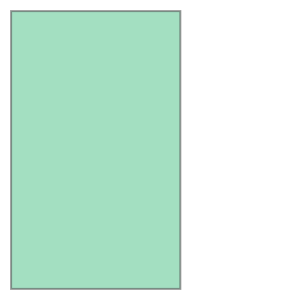

In [7]:
visium_sdata["my_shapes"].geometry.iloc[0]

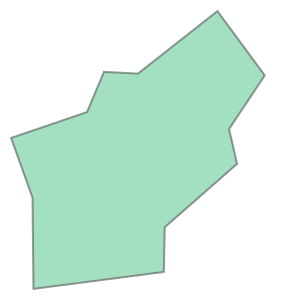

In [8]:
visium_sdata["my_shapes"].geometry.iloc[2]

## Manipulating the shapes in napari

Here is an example of how we can use napari to move/modify/delete some of the shapes, and save them to another layer (in-place overwrite is also supported).

Interactive(visium_sdata)

![](attachments/rois1.gif)

We saved the new layer as `my_shapes_2` inside the same `SpatialData` object (again using the `"aligned"` coordinate system).

As above, let's hardcode the shapes to make this notebook reproducible.

In [10]:
shape0 = np.array([[3471.0, 7290.0, 7290.0, 3471.0, 3471.0], [5848.0, 5848.0, 12117.0, 12117.0, 5848.0]])

shape1 = np.array([[18278.0, 21269.0, 21269.0, 18278.0, 18278.0], [3435.0, 3435.0, 8118.0, 8118.0, 3435.0]])

shape2 = np.array(
    [
        [
            37049.0,
            28114.0,
            26745.0,
            26060.0,
            4696.0,
            23863.0,
            25160.0,
            29159.0,
            29195.0,
            32113.0,
            31789.0,
            33230.0,
            37049.0,
        ],
        [
            34274.0,
            20764.0,
            20836.0,
            19215.0,
            20116.0,
            15756.0,
            84.0,
            12766.0,
            14567.0,
            17125.0,
            18530.0,
            20692.0,
            34274.0,
        ],
    ]
)

gdf = GeoDataFrame({"geometry": [numpy_to_shapely(shape0), numpy_to_shapely(shape1), numpy_to_shapely(shape2)]})
gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})
visium_sdata.shapes["my_shapes_2"] = gdf

In [11]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
│     ├── 'lass0o': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'lasso': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'lassso': GeoDataFrame shape: (1, 1) (2D shapes)
│     ├── 'my_shapes': GeoDataFrame shape: (3, 1) (2D shapes)
│     └── 'my_shapes_2': GeoDataFrame shape: (3, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'gen

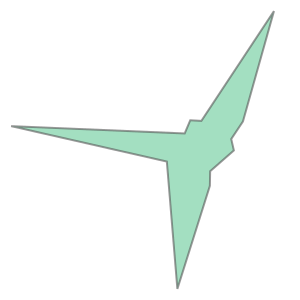

In [12]:
visium_sdata["my_shapes_2"].geometry.iloc[2]

## Lasso annotations
We are working with the `napari` developers for enabling a lasso tool for drawing anatomical annotations. This functionality will be part of `napari` as a new button in the user interface. With `SpatialData` it will be possible to save and represent the annotatoins in-memory, as shown above. The lasso tool will have support for both mouse/trackpad and graphic tables.

In the GIF you can see a preview, the experimental code is available at https://github.com/napari/napari/pull/5555.

![](attachments/rois2.gif)

In [14]:
# we rounded the coordinates to make it less verbose here in the notebook
shape0 = (
    np.array(
        [
            [
                182.0,
                181.0,
                179.0,
                178.0,
                174.0,
                173.0,
                172.0,
                168.0,
                165.0,
                164.0,
                164.0,
                166.0,
                167.0,
                168.0,
                169.0,
                169.0,
                168.0,
                166.0,
                163.0,
                163.0,
                163.0,
                164.0,
                165.0,
                167.0,
                168.0,
                169.0,
                172.0,
                173.0,
                174.0,
                175.0,
                180.0,
                185.0,
                187.0,
                188.0,
                189.0,
                190.0,
                191.0,
                192.0,
                193.0,
                194.0,
                196.0,
                198.0,
                200.0,
                202.0,
                205.0,
                207.0,
                209.0,
                211.0,
                212.0,
                213.0,
                215.0,
                215.0,
                216.0,
                216.0,
                215.0,
                215.0,
                214.0,
                212.0,
                211.0,
                209.0,
                208.0,
                208.0,
                206.0,
                205.0,
                204.0,
                202.0,
                200.0,
                196.0,
                195.0,
                195.0,
                195.0,
                194.0,
                192.0,
                190.0,
                189.0,
                186.0,
                184.0,
                184.0,
                183.0,
                184.0,
                185.0,
                186.0,
                186.0,
                184.0,
                182.0,
                182.0,
                182.0,
                183.0,
                183.0,
                183.0,
                182.0,
                182.0,
                183.0,
                183.0,
                181.0,
                178.0,
                178.0,
                178.0,
                179.0,
                180.0,
                182.0,
                182.0,
                183.0,
                183.0,
                182.0,
            ],
            [
                105.0,
                105.0,
                106.0,
                107.0,
                108.0,
                109.0,
                110.0,
                112.0,
                114.0,
                115.0,
                118.0,
                121.0,
                122.0,
                123.0,
                125.0,
                126.0,
                129.0,
                136.0,
                140.0,
                141.0,
                143.0,
                151.0,
                153.0,
                155.0,
                157.0,
                158.0,
                160.0,
                162.0,
                162.0,
                163.0,
                168.0,
                173.0,
                174.0,
                174.0,
                175.0,
                176.0,
                178.0,
                179.0,
                179.0,
                181.0,
                181.0,
                182.0,
                183.0,
                183.0,
                183.0,
                183.0,
                182.0,
                181.0,
                179.0,
                177.0,
                174.0,
                173.0,
                170.0,
                167.0,
                164.0,
                160.0,
                159.0,
                158.0,
                159.0,
                161.0,
                161.0,
                161.0,
                158.0,
                156.0,
                156.0,
                156.0,
                157.0,
                160.0,
                161.0,
                162.0,
                164.0,
                164.0,
                164.0,
                162.0,
                161.0,
                160.0,
                159.0,
                157.0,
                156.0,
                153.0,
                151.0,
                148.0,
                147.0,
                145.0,
                144.0,
                143.0,
                141.0,
                139.0,
                137.0,
                136.0,
                135.0,
                134.0,
                132.0,
                131.0,
                129.0,
                126.0,
                123.0,
                120.0,
                118.0,
                115.0,
                112.0,
                111.0,
                110.0,
                109.0,
                105.0,
            ],
        ]
    )
    * 100
)


gdf = GeoDataFrame({"geometry": [numpy_to_shapely(shape0)]})
gdf = ShapesModel.parse(gdf, transformations={"aligned": Identity()})
visium_sdata.shapes["lasso"] = gdf

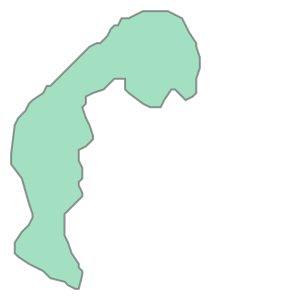

In [15]:
visium_sdata.shapes["lasso"].geometry.iloc[0]

## Limitations

Currently we support saving rectangles, polygons and points with `napari` (see the landmark tutorial). We currently don't support saving circles, ellipses or segments. Furthermore, we ignore the style parameters that `napari` provides, such us fill color, border color, points size and line width. If you are interested in saving these types of annotations please get in touch with us or join the NGFF discussions on annotations in GitHub.


## Visualising SpatialData object with Interactive from napari-spatialdata

In [ ]:
Interactive(visium_sdata, headless=True)